<a href="https://colab.research.google.com/github/ukhyun-lee/stock_market_analysis/blob/main/AI%EC%A4%91%EA%B8%89/AI%EC%8B%A4%EC%8A%B5_8%EC%9B%9414%EC%9D%BC(%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%983).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

In [2]:
a = np.array([[1,2],[3,4]])

In [3]:
b = np.array([[5,6],[7,8]])

In [4]:
c = np.array([[5,6],[7,8], [9,10]])

In [5]:
print(np.concatenate((a,b), axis=0))

[[1 2]
 [3 4]
 [5 6]
 [7 8]]


In [6]:
print(np.stack((a,b), axis=0))

[[[1 2]
  [3 4]]

 [[5 6]
  [7 8]]]


In [7]:
print(np.concatenate((a,b), axis=1))

[[1 2 5 6]
 [3 4 7 8]]


In [8]:
print(np.stack((a,b), axis=1))

[[[1 2]
  [5 6]]

 [[3 4]
  [7 8]]]


In [9]:
print(np.concatenate((a,c), axis=0))

[[ 1  2]
 [ 3  4]
 [ 5  6]
 [ 7  8]
 [ 9 10]]


In [10]:
print(np.stack((a,c), axis=0))   #차원이 다름

ValueError: ignored

In [11]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

torch.Size([1728, 6])
torch.Size([6912])
[(4, 2), (4, 2), (4, 2), (3, 2), (3, 2), (3, 2)]
1383
1383
345
345


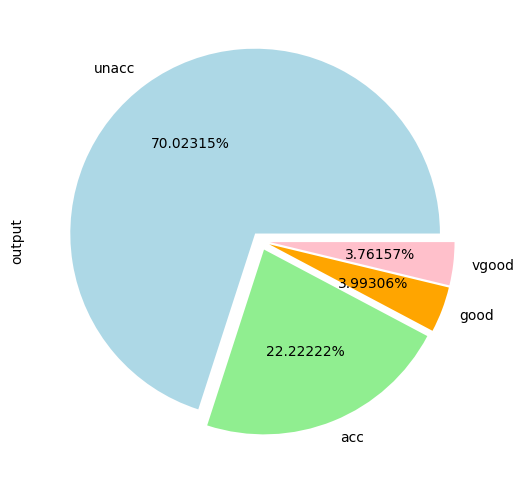

In [12]:
dataset = pd.read_csv('sample_data/car_evaluation.csv')
dataset.head()

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
dataset.output.value_counts().plot(kind='pie', autopct='%0.05f%%', colors=['lightblue', 'lightgreen', 'orange', 'pink'], explode=(0.05, 0.05, 0.05, 0.05))

categorical_columns = ['price', 'maint', 'doors', 'persons', 'lug_capacity', 'safety']

for category in categorical_columns:
    dataset[category] = dataset[category].astype('category')

price = dataset['price'].cat.codes.values
maint = dataset['maint'].cat.codes.values
doors = dataset['doors'].cat.codes.values
persons = dataset['persons'].cat.codes.values
lug_capacity = dataset['lug_capacity'].cat.codes.values
safety = dataset['safety'].cat.codes.values

categorical_data = np.stack([price, maint, doors, persons, lug_capacity, safety], 1)
categorical_data[:10]

categorical_data = torch.tensor(categorical_data, dtype=torch.int64)
categorical_data[:10]

outputs1 = pd.get_dummies(dataset.output)
outputs2 = outputs1.values
outputs3 = torch.tensor(outputs2).flatten()

print(categorical_data.shape)
print(outputs3.shape)

categorical_column_sizes = [len(dataset[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]
print(categorical_embedding_sizes)

total_records = 1728
test_records = int(total_records * .2)# ------ 전체 데이터 중 20%를 테스트 용도로 사용

categorical_train_data = categorical_data[:total_records - test_records]
categorical_test_data = categorical_data[total_records - test_records:total_records]
train_outputs = outputs3[:total_records - test_records]
test_outputs = outputs3[total_records - test_records:total_records]

print(len(categorical_train_data))
print(len(train_outputs))
print(len(categorical_test_data))
print(len(test_outputs))

In [13]:
class Model(nn.Module): #nn.Module 부모클래스 상속
  def __init__ (self, embedding_size, output_size, layers, p=0.4):   #4, [200,100,50]
      super().__init__() #self 사용안한다, 부모것(nnModlue init) 사용(초기화 완료)
      self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
      self.all_embeddings.dropout = nn.Dropout(p)

      all_layers = []
      num_categirical_cols = sum(nf for ni, nf in embedding_size)
      input_size = num_categirical_cols

      for i in all_layers:
          all_layers.append(nn.Linear(input_size, i))
          all_layers.append(nn.ReLU(inplace=True))
          all_layers.append(nn.BatchNormal1d(i))
          all_layers.append(nn.Dropout(p))
          input_size = i
          all_layers.append(nn.Linear(layers[-1],output_size))
          self.layers = nn.Sequential(*all_layers)

  def forward(self, x_categorical):
      embeddings = []
      for i,e in enumerate(self, all_embeddings):
          embeddings.append(e(x_categorical[:,i]))
          x = torch.cat(embeddings, 1)
          x = torch.embedding_dropout(x)
          x = self.layers(x)
          return x



In [19]:
model = Model(categorical_embedding_sizes, 4, [200,100,50], p=0.4) # 층별 노드 갯수, output 수
print(model)

Model(
  (all_embeddings): ModuleList(
    (0-2): 3 x Embedding(4, 2)
    (3-5): 3 x Embedding(3, 2)
    (6): Dropout(p=0.4, inplace=False)
  )
)


In [20]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [22]:
#전체 코딩
class Model(nn.Module):
    def __init__(self, embedding_size, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)

        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))
        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)
        x = self.layers(x)
        return x

model = Model(categorical_embedding_sizes, 4, [200,100,50], p=0.4)
print(model)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

if torch.cuda.is_available():
    device = torch.device('cuda')
else :
    device = torch.device('cpu')

epochs = 500
aggregated_losses = []
train_outputs = train_outputs.to(device=device, dtype=torch.int64)
for i in range(epochs):
    i += 1
    y_pred = model(categorical_train_data).to(device)  #device 셋팅시 to(device) 꼭 작성
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss)

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

Model(
  (all_embeddings): ModuleList(
    (0-2): 3 x Embedding(4, 2)
    (3-5): 3 x Embedding(3, 2)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=4, bias=True)
  )
)
epoch:   1 loss: 1.52905488
epoch:  26 loss: 1.29390073
epoch:  51 loss: 1.22815168
epoch:  76 l

In [72]:
test_outputs = test_outputs.to(device=device, dtype=torch.int64)
with torch.no_grad():
  y_val = model(categorical_test_data).to(device=device)  #device 셋팅시 to(device) 꼭 작성
  loss = loss_function(y_val, test_outputs.to(device=device, dtype=torch.int64))
  #loss = loss_function(y_val, test_outputs)
print(f'Loss: {loss:.8f}')
print(y_val[:5])

Loss: 0.55272591
tensor([[ 2.6408,  1.5708, -2.6759, -3.0094],
        [ 1.9318,  1.0124, -2.4920, -2.6784],
        [ 1.3676,  0.8933, -1.8410, -1.9751],
        [ 2.6349,  1.3978, -1.9517, -2.2353],
        [ 3.0167,  1.7830, -3.1165, -3.1094]], device='cuda:0')


In [71]:
#y_val = np.argmax(y_val, axis=1)
#y_val = np.argmax(y_val.cpu().numpy(), axis=1)  #GPU사용시
y_val = np.argmax(y_val.cpu(), axis=1)   #GPU사용시
print(y_val[:5])

tensor([0, 0, 0, 0, 0])


In [74]:
class Model(nn.Module):
    def __init__(self, embedding_size, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)

        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))
        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)
        x = self.layers(x)
        return x

model = Model(categorical_embedding_sizes, 4, [200,100,50], p=0.4)
print(model)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

if torch.cuda.is_available():
    device = torch.device('cuda')
else :
    device = torch.device('cpu')

epochs = 500
aggregated_losses = []
train_outputs = train_outputs.to(device=device, dtype=torch.int64)
for i in range(epochs):
    i += 1
    y_pred = model(categorical_train_data).to(device)
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss)

    if i % 25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

test_outputs = test_outputs.to(device=device, dtype=torch.int64)
with torch.no_grad():
    y_val = model(categorical_test_data)
    #GPU 사용 시 다음 코드
    y_val = y_val.to(device=device)
    loss = loss_function(y_val, test_outputs.to(device=device, dtype=torch.int64))
    #CPU 사용 시 다음 코드
    #y_val = model(categorical_test_data)
    #loss = loss_function(y_val, test_outputs)
print(f'Loss: {loss:.8f}')
print(y_val[:5])
#GPU 사용 시 다음 코드
y_val = np.argmax(y_val.cpu(), axis=1)
#CPU 사용 시 다음 코드
#y_val = np.argmax(y_val, axis=1)
print(y_val[:5])

Model(
  (all_embeddings): ModuleList(
    (0-2): 3 x Embedding(4, 2)
    (3-5): 3 x Embedding(3, 2)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=4, bias=True)
  )
)
epoch:   1 loss: 1.54832399
epoch:  26 loss: 1.40340686
epoch:  51 loss: 1.29952765
epoch:  76 l

In [75]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [76]:
import warnings
warnings.filterwarnings('ignore')
print(confusion_matrix(test_outputs.cpu().numpy(), y_val))
print(classification_report(test_outputs.cpu().numpy(), y_val))
print(accuracy_score(test_outputs.cpu().numpy(), y_val))

[[259   0]
 [ 86   0]]
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       259
           1       0.00      0.00      0.00        86

    accuracy                           0.75       345
   macro avg       0.38      0.50      0.43       345
weighted avg       0.56      0.75      0.64       345

0.7507246376811594


https://ai-com.tistory.com/entry/ML-%EB%B6%84%EB%A5%98-%EC%84%B1%EB%8A%A5-%EC%A7%80%ED%91%9C-Precision%EC%A0%95%EB%B0%80%EB%8F%84-Recall%EC%9E%AC%ED%98%84%EC%9C%A8